# Install Torch

In [1]:
!pip uninstall -y pillow
!CC="cc -mavx2" pip install -U --force-reinstall pillow-simd


Uninstalling Pillow-5.1.0:
  Successfully uninstalled Pillow-5.1.0
torchvision 0.2.1 requires pillow>=4.1.1, which is not installed.
scikit-image 0.13.1 requires pillow>=2.1.0, which is not installed.
  Found existing installation: Pillow-SIMD 5.1.1.post0
    Uninstalling Pillow-SIMD-5.1.1.post0:
      Successfully uninstalled Pillow-SIMD-5.1.1.post0


In [2]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision
print(torchvision.get_image_backend())

PIL


In [3]:
!pip install tqdm

# Imports

In [0]:
import torch
import os
import sys
import logging
import io
from tqdm import tqdm
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

In [0]:
%matplotlib inline

# Parameters

In [0]:
base_dir = '/content/fashion'
data_dir = base_dir + os.sep + 'data'
input_dir = data_dir + os.sep + 'input'
output_dir = data_dir + os.sep + 'output'
train_zip = input_dir + os.sep + 'train_data.zip'
val_zip = input_dir + os.sep + 'validation_data.zip'
train_dir = input_dir + os.sep + 'train_data'
val_dir = input_dir + os.sep + 'validation_data'
train_id = "1rx1rL8RUAggN4hKlrYLtpdQagtUWmIbO"
val_id = "1U19eWiBFJ6wGcFk47l6g9mmoWp1i4hPY"
# train_labels_id = "1NOoWniR3ioqPKbVWoaWGy4HPDzZAAJX9"
train_labels_id = "1X7TpWyxxtmCT5rw__7OKus_W4fh8xpKO" # small dataset
val_labels_id = "1d9RuQTx5E8qFxraIu6B4rDTOC4sx2xXT"
test_labels_id = "1VwzGCJfOL13pk1Wi-xPHQ6mVnofy9_Z4"
# train_labels_json = input_dir + os.sep + 'train.json'
train_labels_json = input_dir + os.sep + 'train_small.json' 
val_labels_json = input_dir + os.sep + 'validation.json'
test_labels_json = input_dir + os.sep + 'test.json'
num_labels = 228
batch_size = 16
image_min_size = 256
nw_input_size = 224
num_workers = 4
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
pretrain_dset_mean = imagenet_mean
pretrain_dset_std = imagenet_std
world_size = 1
dist_url = 'file://' + output_dir + os.sep + 'dfile'
dist_backend = 'gloo'
distributed = world_size > 1
arch = 'resnet50'
pretrained = True
resume = False

In [7]:
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


7003
True
Tesla K80


In [0]:
cudnn.benchmark = True

In [0]:
os.makedirs(base_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Download Dataset

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import json

def md5_hash(fname, blocksize=4096):
    """ compute md5hash of a file """
    import hashlib
    hash = ''
    if not os.path.exists(fname):
        errmsg = "File %s does not exist" % (fname)
        print(errmsg)
        return ''
    try:
        hasher = hashlib.md5()
        with open(fname, 'rb') as f:
            buf = f.read(blocksize)
            while len(buf) > 0:
                hasher.update(buf)
                buf = f.read(blocksize)
        hash = hasher.hexdigest()
    except:
        print("Exception in hashing file")
        raise
    return hash

def _download(drive_service, file_id, loc):
  request = drive_service.files().get_media(fileId=file_id)
  fh = io.FileIO(loc, mode='wb')
  downloader = MediaIoBaseDownload(fh, request, chunksize=1024*1024)
  prev_progress = 0
  done = False
  with tqdm(total=100) as pbar:
    while done is False:
      status, done = downloader.next_chunk()
      if status:
        # print("Download %d%%." % int(status.progress() * 100))
        pbar.update(int(100 *(status.progress() - prev_progress)))
        prev_progress = status.progress()
  print("Download Complete!")
  file_size = os.path.getsize(loc)
  print("Downloaded %d bytes" % (file_size))

def download(file_id, loc):
  """Downloads a file to local file system."""  
  drive_service = build('drive', 'v3')
  
  request_mdata = drive_service.files().list(fields="files(md5Checksum, originalFilename, id)")
  rh = io.BytesIO()
  downloader_mdata = MediaIoBaseDownload(rh, request_mdata, chunksize=1024*1024)
  done = False
  while not done:
    _, done = downloader_mdata.next_chunk()
  mdata = json.loads(rh.getvalue())
  found = False
  md5drive = ''
  fname = ''
  for x in mdata['files']:
    if x['id'] == file_id:
      found = True
      md5drive = x['md5Checksum']
      fname = x['originalFilename']
      break
  if not found:
    print("{:s} : not found on gdrive".format(file_id))
  else:
    if os.path.exists(loc):
      if md5drive == md5_hash(loc):
        print("{:s} : file already present on colab".format(loc))
      else:
        print("{:s} [gdrive] and {:s} [colab] : md5 mismatch ... downloading".format(fname, loc))
        _download(drive_service, file_id, loc)
    else:
      print("{:s} not present on colab ... downloading ...".format(loc))
      _download(drive_service, file_id, loc)
        


In [12]:
download(train_id, train_zip)
download(val_id, val_zip)
download(train_labels_id, train_labels_json)
download(val_labels_id, val_labels_json)
download(test_labels_id, test_labels_json)

  0%|          | 0/100 [00:00<?, ?it/s]

/content/fashion/data/input/train_data.zip not present on colab ... downloading ...


  0%|          | 0/100 [03:00<?, ?it/s]


Download Complete!
Downloaded 623133900 bytes


  0%|          | 0/100 [00:00<?, ?it/s]

/content/fashion/data/input/validation_data.zip not present on colab ... downloading ...


  0%|          | 0/100 [03:16<?, ?it/s]


Download Complete!
Downloaded 649513008 bytes


  0%|          | 0/100 [00:00<?, ?it/s]

/content/fashion/data/input/train_small.json not present on colab ... downloading ...


 99%|█████████▉| 99/100 [00:01<00:00, 51.87it/s]


Download Complete!
Downloaded 3740426 bytes


  0%|          | 0/100 [00:00<?, ?it/s]

/content/fashion/data/input/validation.json not present on colab ... downloading ...


 96%|█████████▌| 96/100 [00:02<00:00, 40.72it/s]


Download Complete!
Downloaded 4222518 bytes


  0%|          | 0/100 [00:00<?, ?it/s]

/content/fashion/data/input/test.json not present on colab ... downloading ...


 99%|█████████▉| 99/100 [00:02<00:00, 33.47it/s]

Download Complete!
Downloaded 5785993 bytes


In [0]:
import shutil
shutil.unpack_archive(train_zip, input_dir)
shutil.unpack_archive(val_zip, input_dir)


In [14]:
!ls -ltr /content/fashion/data/input

total 1256744
-rw-r--r-- 1 root root 623133900 May 21 18:46 train_data.zip
-rw-r--r-- 1 root root 649513008 May 21 18:49 validation_data.zip
-rw-r--r-- 1 root root   3740426 May 21 18:49 train_small.json
-rw-r--r-- 1 root root   4222518 May 21 18:49 validation.json
-rw-r--r-- 1 root root   5785993 May 21 18:49 test.json
drwxr-xr-x 2 root root    241664 May 21 18:49 train_data
drwxr-xr-x 2 root root    241664 May 21 18:50 validation_data


In [15]:
!ls -ltr /content/fashion/data/input/train_data | head

total 636932
-rw-r--r-- 1 root root  61060 May 21 18:49 1.jpg
-rw-r--r-- 1 root root  61806 May 21 18:49 10.jpg
-rw-r--r-- 1 root root  97998 May 21 18:49 100.jpg
-rw-r--r-- 1 root root  42627 May 21 18:49 1000.jpg
-rw-r--r-- 1 root root 105654 May 21 18:49 10000.jpg
-rw-r--r-- 1 root root  24032 May 21 18:49 1002.jpg
-rw-r--r-- 1 root root  49370 May 21 18:49 1001.jpg
-rw-r--r-- 1 root root  68407 May 21 18:49 1004.jpg
-rw-r--r-- 1 root root  95681 May 21 18:49 1003.jpg
ls: write error: Broken pipe


In [16]:
!ls -ltr /content/fashion/data/input/validation_data | head

total 663036
-rw-r--r-- 1 root root  89139 May 21 18:49 1.jpg
-rw-r--r-- 1 root root  61895 May 21 18:49 10.jpg
-rw-r--r-- 1 root root  56745 May 21 18:49 100.jpg
-rw-r--r-- 1 root root  53685 May 21 18:49 1001.jpg
-rw-r--r-- 1 root root  55370 May 21 18:49 1000.jpg
-rw-r--r-- 1 root root  81057 May 21 18:49 1002.jpg
-rw-r--r-- 1 root root  70008 May 21 18:49 1005.jpg
-rw-r--r-- 1 root root  38732 May 21 18:49 1004.jpg
-rw-r--r-- 1 root root  56689 May 21 18:49 1003.jpg
ls: write error: Broken pipe


# Dataset

In [0]:
import torch.utils.data as data
from copy import copy
import numpy as np

def fetch_labels(annotations, num_labels):
  labels = {}
  for x in annotations:
    arr = np.zeros((num_labels,), dtype=np.float32)
    for y in map(int, x['labelId']):
      arr[y-1] = 1.0
    # 0-indexed
    labels[int(x['imageId'])-1] = copy(arr)
  return labels

def json_to_dict(fpath):
  import json
  with open(fpath) as f: 
    D = json.load(f)
  return D

def get_labelinfo(annotations):
  from collections import namedtuple
  labelinfo = namedtuple('labelinfo', "set min max count")
  labelinfo.set = set()
  for x in annotations:
    labelinfo.set.update(map(int, x['labelId']))
  labelinfo.min = min(labelinfo.set)
  labelinfo.max = max(labelinfo.set)
  labelinfo.count = len(labelinfo.set)
  return labelinfo

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def pil_loader(path):
    from PIL import Image 
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

      
class FashionDataset(data.Dataset):
  """Fashion dataset CVPR challenge.
     Adapted from torchvision ImageFolder.
     Similar to ImageFolder with the following differences:
     1. Multilabel
     2. Directory structure where all images are directly in the root folder
     3. Labels are read from json file
   
  Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
    
  """

  def __init__(self, root, metadata_file, num_labels=228, transform=None, target_transform=None,
               loader=default_loader):
    extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']
    self.num_labels = num_labels
    self.images = {}
    self.metadata_file = metadata_file
    self.metadata = json_to_dict(self.metadata_file)
    self.transform = transform
    self.root = root
    self.target_transform = target_transform
    self.loader = loader
    self.labelinfo = get_labelinfo(self.metadata['annotations'])
    self.labels = fetch_labels(self.metadata['annotations'], self.num_labels)

    for x in self.metadata['images']:
      # 0-indexed
      self.images[int(x['imageId'])-1] = '%s%s%d.jpg' % (root, os.sep, int(x['imageId']))  
    

  def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.images[index], self.labels[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

  def __len__(self):
    return len(self.images)
  
  def __repr__(self):
    fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
    fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
    fmt_str += '    Number of labels: {}\n'.format(self.labelinfo.count)
    fmt_str += '    Root Location: {}\n'.format(self.root)
    fmt_str += '    Metadata file: {}\n'.format(self.metadata_file)
    tmp = '    Transforms (if any): '
    fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Target Transforms (if any): '
    fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Loader: '
    fmt_str += '\n{0}{1}'.format(tmp, self.loader.__name__)
    return fmt_str

  

In [0]:
import torchvision.transforms as transforms

train_tform = transforms.Compose([transforms.RandomResizedCrop(nw_input_size),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=pretrain_dset_mean,
                                                        std=pretrain_dset_std)
                                 ])

val_tform = transforms.Compose([transforms.Resize(image_min_size),
                                transforms.CenterCrop(nw_input_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=pretrain_dset_mean,
                                                     std=pretrain_dset_std)
                               ])

In [19]:
train_dset = FashionDataset(train_dir, train_labels_json, num_labels, transform=train_tform)
val_dset = FashionDataset(val_dir, val_labels_json, num_labels, transform=val_tform)


print(train_dset)
print(val_dset)

Dataset FashionDataset
    Number of datapoints: 10000
    Number of labels: 221
    Root Location: /content/fashion/data/input/train_data
    Metadata file: /content/fashion/data/input/train_small.json
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None
    Loader: default_loader
Dataset FashionDataset
    Number of datapoints: 9897
    Number of labels: 225
    Root Location: /content/fashion/data/input/validation_data
    Metadata file: /content/fashion/data/input/validation.json
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                      

In [0]:
def tensor_to_numpy(t, avg, std):
  return (255.0 * (np.transpose(np.asarray(t), (1, 2, 0)) * std + avg)).astype(np.uint8)
  

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


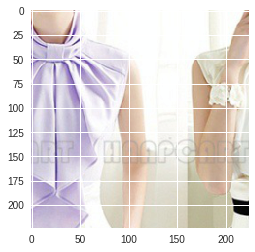

In [21]:
rnd1 = np.random.randint(len(train_dset))
im1, lbl1 = train_dset[rnd1]
imshow(tensor_to_numpy(im1, pretrain_dset_mean, pretrain_dset_std))
print(lbl1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


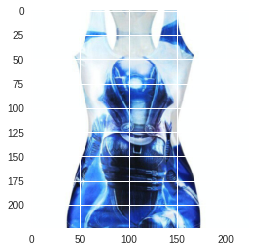

In [22]:
rnd2 = np.random.randint(len(val_dset))
im2, lbl2 = val_dset[rnd2]
imshow(tensor_to_numpy(im2, pretrain_dset_mean, pretrain_dset_std))
print(lbl2)

# DataLoader

In [0]:
if distributed:
    dist.init_process_group(backend=dist_backend,
                            init_method=dist_url,
                            world_size=world_size)


In [0]:
from torch.utils.data.distributed import DistributedSampler 


if distributed:
  train_sampler = DistributedSampler(train_dset)
else:
  train_sampler = None

train_loader = torch.utils.data.DataLoader(train_dset,
                                           batch_size=batch_size,
                                           shuffle=(train_sampler is None),
                                           num_workers=num_workers,
                                           pin_memory=True,
                                           sampler=train_sampler
                                          )

val_loader = torch.utils.data.DataLoader(val_dset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=num_workers,
                                         pin_memory=True
                                        )


In [0]:
train_images, train_labels = next(iter(train_loader))

In [26]:
rnd11 = np.random.randint(batch_size)
print(train_images[rnd11,:,:,:])
print(train_labels[rnd11, :])


( 0 ,.,.) = 
  1.0159  1.0159  1.0673  ...   2.2318  2.2318  2.2318
  1.1872  1.2043  1.0331  ...   2.2318  2.2318  2.2318
  1.4612  1.4612  1.2043  ...   2.2318  2.2318  2.2318
           ...             ⋱             ...          
 -0.0116  0.2282  0.3823  ...   0.4337  0.3309 -0.9877
  0.0227  0.2282  0.3652  ...   0.4166  0.5022 -0.6109
 -0.0458  0.1768  0.2624  ...   0.4166  0.5193 -0.0801

( 1 ,.,.) = 
  0.2927  0.2927  0.3277  ...   2.4286  2.4286  2.4286
  0.4328  0.4503  0.2752  ...   2.4286  2.4286  2.4286
  0.7479  0.7304  0.4678  ...   2.4286  2.4286  2.4286
           ...             ⋱             ...          
 -0.2500  0.0301  0.1877  ...   0.4328  0.3803 -0.9503
 -0.2325  0.0126  0.1702  ...   0.4153  0.5378 -0.5826
 -0.2325  0.0126  0.1001  ...   0.4328  0.5378 -0.0399

( 2 ,.,.) = 
 -0.1835 -0.1835 -0.0790  ...   2.6400  2.6400  2.6400
 -0.0615 -0.0267 -0.1487  ...   2.6400  2.6400  2.6400
  0.2173  0.2348  0.0256  ...   2.6400  2.6400  2.6400
           ...         

In [0]:
val_images, val_labels = next(iter(val_loader))

In [28]:
rnd21 = np.random.randint(batch_size)
print(val_images[rnd21,:,:,:])
print(val_labels[rnd21, :])


( 0 ,.,.) = 
  2.2318  2.2318  2.2318  ...  -0.9363 -1.1760 -1.2103
  2.2318  2.2147  2.2489  ...  -1.0390 -1.2959 -1.0562
  2.0948  2.0263  2.0434  ...  -1.1589 -1.3815 -1.2103
           ...             ⋱             ...          
  0.8618  0.9646  0.9646  ...   2.2489  2.2489  2.2489
  0.8104  0.9817  1.1358  ...   2.2489  2.2489  2.2489
  0.9646  0.9817  1.3070  ...   2.2489  2.2489  2.2489

( 1 ,.,.) = 
  2.3936  2.3936  2.4111  ...  -0.7577 -1.0553 -1.1078
  2.4111  2.3936  2.4286  ...  -0.8627 -1.1779 -0.9328
  2.2710  2.2185  2.2185  ...  -0.9853 -1.2829 -1.1078
           ...             ⋱             ...          
  1.0280  1.1155  0.9930  ...   2.4286  2.4286  2.4286
  0.9755  1.1331  1.1681  ...   2.4286  2.4286  2.4286
  1.1506  1.1331  1.3606  ...   2.4286  2.4286  2.4286

( 2 ,.,.) = 
  2.6051  2.5877  2.6051  ...  -0.6193 -0.8633 -0.8981
  2.6051  2.5703  2.6051  ...  -0.7413 -1.0201 -0.7936
  2.4831  2.3786  2.3611  ...  -0.8458 -1.1247 -0.9504
           ...         


# Model

In [0]:
def create_model(arch, pretrained=True, resume=False, distributed=False):
  if pretrained:
      print("=> using pre-trained model '{}'".format(arch))
      model = models.__dict__[arch](pretrained=True)
  else:
      print("=> creating model '{}'".format(arch))
      model = models.__dict__[arch]()

  if not distributed:
      if arch.startswith('alexnet') or arch.startswith('vgg'):
          model.features = torch.nn.DataParallel(model.features)
          model.cuda()
      else:
          model = torch.nn.DataParallel(model).cuda()
  else:
      model.cuda()
      model = torch.nn.parallel.DistributedDataParallel(model)


In [33]:
model = create_model(arch, pretrained=pretrained, resume=resume, distributed=distributed)

=> using pre-trained model 'resnet50'


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /content/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 38249334.18it/s]


# Loss Function


# Update Rule

# Training Loop


# Save Results